# Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import re
import json
import imblearn
import sklearn.metrics as metrics
from collections import Counter
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize, RegexpTokenizer
from numpy import where
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler

# Opening Dataset and convert it into Array

In [2]:
dataset = []
with open ('../dataset/dataset.csv',encoding="latin1") as csvfile:
    readCSV = csv.DictReader(csvfile, delimiter=';')
    
    for row in readCSV:
        tweets = row['tweet']    
        usernames = row['username']
        hashtags = row['hashtag']
        dates = row['date']
        intent = row['intent']
        emotion = row['emotion']
        dataset.append({
            'date' : dates,
            'username' : usernames,
            'tweet' : tweets,
            'hashtag' : hashtags,
            'intent' : intent,
            'emotion' : emotion
        })
            
        
print("total tweets : " , len(dataset))

total tweets :  1734


# Normalization

The purpose of normalization are to remove non Indonesian word such as slang words and abbreviations will be converted to standard Indonesian words. the list is created by iterating to each feature in the dataset and list them with their normal word (standar word)

## Load list of typo words

In [3]:
typo_list = []
with open ('../feature_list/typo.csv',encoding="latin1") as csvfile:
    readCSV = csv.DictReader(csvfile, delimiter=',')
    for row in readCSV:
        word = row['typo']    
        standard_word = row['standard_form']
        typo_list.append({
            'word' : word,
            'standard_word' : standard_word
        })  
        #print(word,",")
print("total typo words : " , len(typo_list))

total typo words :  169


## Load list of abbreviations words

In [4]:
abbreviation_list = []
with open ('../feature_list/abbreviation.csv',encoding="latin1") as csvfile:
    readCSV = csv.DictReader(csvfile, delimiter=',')
    for row in readCSV:
        word = row['abbreviations']    
        standard_word = row['non-abbreviations']
        abbreviation_list.append({
            'word' : word,
            'standard_word' : standard_word
        })  
        #print(word,",")
print("total abbreviation words : " , len(abbreviation_list))

total abbreviation words :  362


## Load list of slang words

In [5]:
slang_list = []
with open ('../feature_list/slangwords.csv',encoding="latin1") as csvfile:
    readCSV = csv.DictReader(csvfile, delimiter=',')
    for row in readCSV:
        word = row['slang_word']    
        standard_word = row['formal_word']
        slang_list.append({
            'word' : word,
            'standard_word' : standard_word
        })     
        #print(word,",")
print("total slang words : " , len(slang_list))

total slang words :  58


## Load combination list of slang words,abbreviation words, and typo words

In [6]:
word_list = []
with open ('../feature_list/word_list.csv',encoding="latin1") as csvfile:
    readCSV = csv.DictReader(csvfile, delimiter=',')
    for row in readCSV:
        word = row['word']    
        standard_word = row['formal_word']
        word_list.append({
            'word' : word,
            'standard_word' : standard_word
        })    
print("total word_list : " , len(word_list))

total word_list :  697


## Normalization

In [7]:
def languagePreprocessing(dataset):
    for row in dataset:
        word_tokens = word_tokenize(row['tweet']) 
        filtered_word = []
        for x in range(len(word_tokens)):
            for n in range(len(word_list)):
                if word_tokens[x] == word_list[n]['word']:
                    word_tokens[x] = word_list[n]['standard_word']
                    filtered_word.append(word_tokens[x])
            filtered_word.append(word_tokens[x])
            filtered_word = list(dict.fromkeys(filtered_word))
        row['tweet']= " ".join(filtered_word)
languagePreprocessing(dataset)

"After each list for each category listed, then I manually combine them into one csv file with two columns which are "word" and standard word".
By iterating each words after tokenization, if the word match in the document, then the word will be changed based on standard word in csv file.

# Stemming, Tokenization, Stopwords removal, remove unnecessary attribute

## Load indonesian stopwords list (source)

In [8]:
#Stopword
stopWords = []
#start getStopWordList
def getStopWordList(stopWordListFileName):
    #read the stopwords file and build a list
    stopWords = []
    stopWords.append('atuser')
    stopWords.append('url')
    stopWords.append('via')

    fp = open(stopWordListFileName, 'r')
    line = fp.readline()
    while line:
        word = line.strip()
        stopWords.append(word)
        line = fp.readline()
    fp.close()
    return stopWords

st = open('../feature_list/stopwordsIDwithnegation.txt', 'r')
stopWords = getStopWordList('../feature_list/stopwordsIDwithnegation.txt')
#end

In [9]:
def preprocessing(dataset):
    # create stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    negation_word = []
    negated_word = []
    for row in dataset:
        #print("before : ",row['tweet'])
        #convert sentence in lowercase
        row['tweet'] = row['tweet'].lower()
        row['tweet'] = re.sub('[^A-Za-z0-9 ]+','', row['tweet'])
        # remove number
        row['tweet'] = re.sub('[0-9]+', '', row['tweet'])
        row['tweet'] = re.sub(r'\d+', '', row['tweet'])
        #Convert www.* or https?://* to URL
        row['tweet'] = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',row['tweet'])
        row['tweet'] = re.sub(r"pictwittercom(\w+)", '',row['tweet'])
        #remove hastag word
        row['tweet'] = re.sub(r"#(\w+)", '',row['tweet'])
        #remove atuser words
        row['tweet'] = row['tweet'].replace('atuser','')
        
       
        #Tokenize
        word_tokens = word_tokenize(row['tweet']) 
        #Stop word removal
        filtered_sentence = [w for w in word_tokens if not w in stopWords]
        row['tweet'] = " ".join(filtered_sentence)
        #stemming
        filtered = [] 
        for v in filtered_sentence:
            filtered.append(stemmer.stem(v))
        row['tweet'] = " ".join(filtered)
preprocessing(dataset)


# Convert to dataframe

In [10]:
df = pd.DataFrame(dataset)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,date,emotion,hashtag,intent,tweet,username
0,07/07/2020 12:14,anger,"['#bansos', '#pandemic', '#koransindo']",negative,politisasi bansos covid menang pilkada awas ke...,pung purwanto
1,29/05/2020 10:19,love,"['#bansos', '#bantuansosial', '#dtks', '#kemen...",positive,bansos bantuansosial dtks tri sosial sumedang ...,ruang berita
2,24/05/2020 00:55,,['#indonesiaterserah'],positive,team rumah indonesiaterserah,abdul latief
3,26/05/2020 07:46,,"['#indonesiaterserah', '#covidiot']",positive,kemarin semangat buka akses zona hijau indones...,omgcorona
4,13/07/2020 23:38,anger,"['#kemendagri', '#pilkada2020', '#bansos']",negative,tito ingat calon tahana manfaat bansos corona ...,republik merdeka banten


In [11]:
for n in range (5):
    print(n, ' ',dataset[n]['tweet'])

0   politisasi bansos covid menang pilkada awas ketat pandemic koransindo
1   bansos bantuansosial dtks tri sosial sumedang jabar indonesia kementeriansosial news ruberid
2   team rumah indonesiaterserah
3   kemarin semangat buka akses zona hijau indonesiaterserah covidiot
4   tito ingat calon tahana manfaat bansos corona gambar kemendagri pilkada


# Check positive and negative classes

In [12]:
filtered_data_negative = df[df["intent"]=='negative']
filtered_data_positive = df[df["intent"]=='positive']


print("Count of positive tweets : ", len(filtered_data_positive))
print("Count of negative tweets : ", len(filtered_data_negative))

Count of positive tweets :  867
Count of negative tweets :  867


## Feature Extraction TF IDF 

In [68]:
X = df['tweet']
y = df['intent']
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20069, random_state = 10,stratify=y)
print(Counter(y_train))
print(Counter(y_test))
#TFIDF
tfidf_vectorizer = TfidfVectorizer() 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()

X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

print(Counter(y))

Counter({'positive': 693, 'negative': 693})
Counter({'negative': 174, 'positive': 174})
Counter({'negative': 867, 'positive': 867})


In [14]:
vocab = tfidf_vectorizer.get_feature_names()
print(len(vocab))

5468


In [15]:
vocab[1001:1014]

['degan',
 'degil',
 'dekat',
 'dekatdihati',
 'dekdekan',
 'delapan',
 'demi',
 'demojakarta',
 'demokrasi',
 'demokrasitirasi',
 'demomusisi',
 'demosantuy',
 'denda']

In [16]:
X[0]

array([0., 0., 0., ..., 0., 0., 0.])

example of feature on the dataset

In [17]:
tf_idf_score = dict(zip(vocab, X[0]))
for row in tf_idf_score:
    if tf_idf_score[row] > 0 :
        print (row, " : ", tf_idf_score[row])

awas  :  0.3394476424165459
bansos  :  0.10962454608759643
covid  :  0.13874536714928698
ketat  :  0.3839786565133397
koransindo  :  0.44725201284934146
menang  :  0.35455822125014896
pandemic  :  0.35455822125014896
pilkada  :  0.31463717812943637
politisasi  :  0.3944792643708616


# Classification Process

## Split train and test data


In [18]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20069, random_state = 10,stratify=y)


print(Counter(y_train))
print(Counter(y_test))

Counter({'positive': 693, 'negative': 693})
Counter({'negative': 174, 'positive': 174})


In [19]:
#X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
#                                                    test_size=0.8, 
#                                                    random_state=42)

The proportion of split and training data are 80:20 which mean 20% of dataset will be use for test dataset and 80% will be used for training dataset.

In [20]:
X_train.shape

(1386, 5468)

In [21]:
y_train.shape

(1386,)

# Build naive bayes classification model

In [69]:
from time import time

text_classifier = MultinomialNB(alpha = 1, fit_prior = True, class_prior = None)
text_classifier.fit(X_train_tfidf, y_train)
text_classifier.classes_

array(['negative', 'positive'], dtype='<U8')

In [70]:
neg_class_prob_sorted = text_classifier.feature_log_prob_
pos_class_prob_sorted = text_classifier.feature_log_prob_

neg_dict = dict(zip(vocab, neg_class_prob_sorted[0]))
pos_dict = dict(zip(vocab, pos_class_prob_sorted[1]))

In [71]:
print("log probability of prior class : ", text_classifier.class_log_prior_)
print("number of features in the model : ",text_classifier.n_features_)

log probability of prior class :  [-0.69314718 -0.69314718]
number of features in the model :  4768


In [72]:
predictions = text_classifier.predict(X_test_tfidf)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.79      0.79      0.79       174
    positive       0.79      0.79      0.79       174

    accuracy                           0.79       348
   macro avg       0.79      0.79      0.79       348
weighted avg       0.79      0.79      0.79       348

0.7873563218390804


In [26]:
count_neg = 0
count_pos = 0
for row in predictions:
    if row == "negative":
        count_neg = count_neg +1 
    if row == "positive":
        count_pos = count_pos +1
        
print("pos : ",count_pos)
print("neg : ",count_neg)

pos :  170
neg :  178


## Inverse transform to obtain tweet text on test data

In [27]:
X_test_text = []
for row in range(len(X_test)):
    X_test_text.append(tfidf_vectorizer.inverse_transform(X_test[row]))

In [28]:
X_test_text = np.array(X_test_text)
X_test_text  = X_test_text.ravel()
X_test_text = np.array(X_test_text)
print(type(X_test_text))

<class 'numpy.ndarray'>


In [29]:
X_test_tweet = []
for tweet in range(len(X_test_text)):
    makeitastring = ' '.join(map(str, X_test_text[tweet]))
    X_test_tweet.append(makeitastring)
    

## Get false positive and false negative on the test data

In [30]:
X_test_tweet = []
for tweet in range(len(X_test_text)):
    makeitastring = ' '.join(map(str, X_test_text[tweet]))
    X_test_tweet.append(makeitastring)
    

In [31]:
d = {'Text':X_test_tweet,'True label':y_test, 'Predicted label' : predictions}
df_test = pd.DataFrame(d)
df_test.head()

,Text,True label,Predicted label
814,indonesiaterserah serah,negative,negative
946,bacotsantuy dirumahaja distancing gibahin indo...,negative,negative
1209,bantu dana hidup indonesiasaveprakerja kartupr...,negative,negative
86,bansos ehh gin hadehh hastag hehehe maksud pan...,negative,negative
836,baik bansos bantu bst ganjar ganjarpranowo gub...,negative,positive


In [32]:
y_test_temp = []
for row in y_test:
    y_test_temp.append(row)

In [33]:
tweet_text_fn = []
true_label_fn = []
predicted_label_fn = []
predicted_label_fp = []
tweet_text_fp = []
true_label_fp = []

In [34]:
for row in range(len(y_test_temp)):
    #false negative
    if(y_test_temp[row] == "positive" and predictions[row] == "negative"):
        #print(X_test_text[row], " - ", y_test_temp[row], " - ",predictions[row])
        tweet_text_fn.append(X_test_text[row])
        true_label_fn.append(y_test_temp[row])
        predicted_label_fn.append(predictions[row])
    #false positive
    if(y_test_temp[row] == "negative" and predictions[row] == "positive"):
        #print(X_test_text[row], " - ", y_test_temp[row], " - ",predictions[row])
        tweet_text_fp.append(X_test_text[row])
        true_label_fp.append(y_test_temp[row])
        predicted_label_fp.append(predictions[row])


In [35]:
tweet_text_fn_ = []
tweet_text_fp_ = []
for x in tweet_text_fn:
    makeitastring = ' '.join(map(str, x))
    tweet_text_fn_.append(makeitastring)
for x in tweet_text_fp:
    makeitastring = ' '.join(map(str, x))
    tweet_text_fp_.append(makeitastring)

In [67]:
print("false positive", len(df_fp))
print("false negative", len(df_fn))
pd.options.display.max_colwidth = 200
print(len(df_fp)+len(df_fn))

false positive 36
false negative 40
76


In [60]:
d = {'False neagtive tweet':tweet_text_fn_}
df_fn = pd.DataFrame(d)


In [62]:
df_fn

,False neagtive tweet
0,galau indonesiaterserah kedamaianbukan madeinmadiun madiun madiunhits physicaldistancing resah sebar socialdistancing stayathome staysafe stopthespread tenang
1,anggar bansos bantu belanja covid daerah indonesia kodiklatad negara rapid tangan tentara terima test
2,angkasapura apairports cilok cnnindonesia derrysulaiman detikcom hitamputiht indonesiaterserah jokowi jual kakek kasih kompasiana menang officialnetnews orangkayagaktau ramadhan republikaonline ru...
3,bacotsantuy birojodoh birojomblo cium dekat dirumahaja indonesiaterserah jauh juni newnormal serius virus welcomejune
4,anonymuos asukabeh bacotsantuy balikindanahaji batam covid dipecatkokdibela dirumahaja fizi hadap hapuscovid indonesiaterserah jokowi pride senyum suryakepri trumpout
5,ayo beda benarbenar bilang dapat depan indonesiaterserah mata musuh nkri pecah sadar takut
6,ambil candydancechallenge covid dinnermate gambar gunung heartsignal indonesiaterserah lanang lihat mutualanig mutualanyuk pandemi sateratu tiktok trisna video
7,ambil belanja digitalisasi jaman maksud platform praktis resikoindonesiaterserah
8,hikmahnyaindonesiaterserah moga rebah
9,air bandara indonesia indonesiaabnormal indonesiaterserah lion lionair pesawat syarat terbang tiketpesawat tumpang


In [63]:
d = {'False positive tweet':tweet_text_fp_}
df_fp = pd.DataFrame(d)
df_fp

,False positive tweet
0,baik bansos bantu bst ganjar ganjarpranowo gubernur indonesia jawa persero pos posindonesia pranowo pt salur sosial tunai
1,adu bandar bansos bantu berantas beritalampung dasar dinas dinsoabandarlampung dinsos kait komisi korupsi kota lampostco lampung lapor menindaklanjuti salur seri sosial tapis terima wilayah
2,indonesiaterserah wtf
3,abdul bansos covid desa halim henti iskandar kena kepala menteri perintah salah untung urus
4,aktor bansos bantuansosial berita bicara bijak catat covid cuat indonesiaindicator influencer isu lepas mang media person publik ruang top
5,beranta covid harunginya indonesiabisa indonesiaterserah jaya moga selesai
6,bansos buka desa informasi jalan kamis kemarin komunikasi malang mesti mis nyambung perintah publik wartadesa
7,bansos dki resap tanah
8,bansos bantul damping dana duga gelap harap keluarga kurun pkh program
9,bansos corona coronavirus covid hak henti kerja miskin orang orangmiskin rakyatmerdeka rmcoid vox


## Confusion Matrix

Confusion matrix, with normalization
[[138  36]
 [ 40 134]]
Normalized confusion matrix
[[0.79310345 0.20689655]
 [0.22988506 0.77011494]]


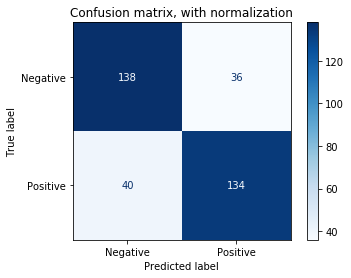

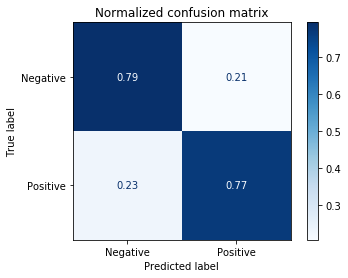

In [38]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, with normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(text_classifier, X_test, y_test,
                                 display_labels=['Negative','Positive'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [39]:
def cuspreprocessing(tweet):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    negation_word = []
    negated_word = []
    count = 0
    for row in tweet:
        #print("before : ",row['tweet'])
        #convert sentence in lowercase
        row = row.lower()
        row = re.sub('[^A-Za-z0-9 ]+','', row)
        # remove number
        row = re.sub('[0-9]+', '', row)
        row = re.sub(r'\d+', '', row)
        #Convert www.* or https?://* to URL
        row = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',row)
        row = re.sub(r"pictwittercom(\w+)", '',row)
        #remove hastag word
        row = re.sub(r"#(\w+)", '',row)
        #remove atuser words
        row = row.replace('atuser','')
        
        #Tokenize
        word_tokens = word_tokenize(row)
        #stemming
        #Stop word removal
        filtered_sentence = [w for w in word_tokens if not w in stopWords]
        row = " ".join(filtered_sentence)
        filtered = [] 
        for v in filtered_sentence:
                filtered.append(stemmer.stem(v))
        row = " ".join(filtered)
    return row

The function above is created to detect negation in single tweet text and transform negated word into "NOT_"  + word.

## Error analysis word order

In [40]:
test_text = ["tidak untuk saat ini tapi , saya senang "]
test_text_after = cuspreprocessing(test_text)
predict = text_classifier.predict(tfidf_vectorizer.transform([test_text_after]))
print(test_text_after)
print(predict)

tapi senang
['negative']


In [41]:
test_text = ["saya senang, tapi tidak untuk saat ini "]
test_text_after = cuspreprocessing(test_text)
predict = text_classifier.predict(tfidf_vectorizer.transform([test_text_after]))
print(test_text_after)
print(predict)

senang tapi
['negative']


the test text on first cell with text "tidak untuk saat ini tapi, saya senang" (not for now, but i am happy) is classified as negative, however if we evaluate the text, it should be classified as positive.
naive bayes ignore word order for text classification problems.

# Data visualization

### Wordcloud for postive and negative tweets

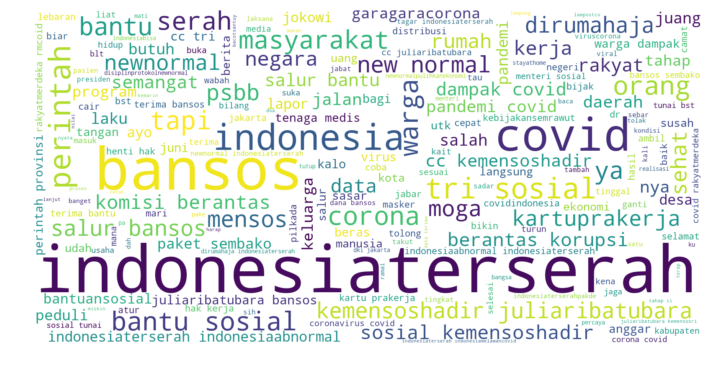

In [42]:
tweet = ''
for row in dataset:
    tweet  = tweet + row['tweet'] + " "
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,background_color='white').generate(tweet)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud positive tweet

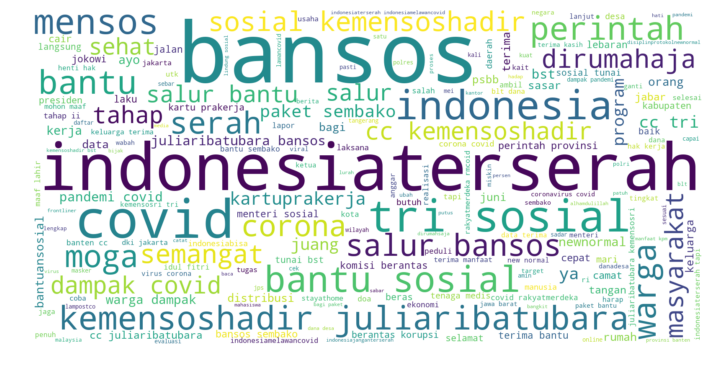

In [43]:
positive_tweet = ''
for row in dataset:
    if row['intent'] == 'positive':
        positive_tweet  = positive_tweet + row['tweet'] + " "
positive_tweet = positive_tweet.replace('atuser ', '')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,background_color='white').generate(positive_tweet)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud negative tweet

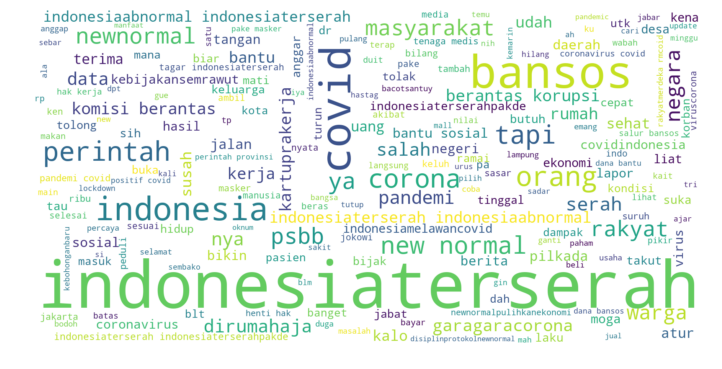

In [44]:
negative_tweet = ''
for row in dataset:
    if row['intent'] == 'negative':
        negative_tweet  = negative_tweet + row['tweet'] + " "
negative_tweet = negative_tweet.replace('at_user ', '')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,background_color='white').generate(negative_tweet)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Hashtag Visualization

In [45]:
def hashtagPreprocessing(dataset):
    # create stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    count = 0
    for row in dataset:
        #print("before : ",row['tweet'])
        #convert sentence in lowercase
        row['hashtag'] = row['hashtag'].lower()
        row['tweet'] = re.sub('[^A-Za-z0-9 ]+','', row['tweet'])
        #remove bracket
        row['hashtag'] = row['hashtag'].replace('[','')
        row['hashtag'] = row['hashtag'].replace(']','')
        #remove #
        row['hashtag'] = row['hashtag'].replace('#','')
        #remove '
        row['hashtag'] = row['hashtag'].replace("'",'')
        row['hashtag'] = row['hashtag'].replace(",",' ')
hashtagPreprocessing(dataset)

##### Code above is to remove unnecessary symbols such as ', #, [ and ] on hastag's column

In [46]:
hashtag = []
for row in dataset:
    word_tokens = word_tokenize(row['hashtag']) 
    for x in range(len(word_tokens)):
        hashtag.append(word_tokens[x])
print(Counter(hashtag))

Counter({'indonesiaterserah': 944, 'bansos': 704, 'covid19': 205, 'kemensoshadir': 101, 'juliaribatubara': 97, 'kemensos': 91, 'covid': 83, 'dirumahaja': 82, '?': 71, 'indonesiaabnormal': 69, 'newnormal': 66, 'kartuprakerja': 62, 'corona': 57, 'covid_19': 55, 'coronavirus': 52, 'indonesiamelawancovid19': 45, 'å¸â¬19': 43, 'indonesia': 38, 'garagaracorona': 32, 'kpk': 31, 'bst': 31, 'covid__19': 30, 'bantuansosial': 29, 'indonesiaterserahpakde': 29, 'kebijakansemrawut': 27, 'psbb': 27, 'mensos': 26, 'covid19indonesia': 26, 'rakyatmerdeka': 24, 'rmcoid': 24, 'blt': 22, 'banten': 21, 'lawancovid19': 21, 'indonesiabisa': 18, 'jokowi': 18, 'lampostco': 18, 'indonesiaambyar': 18, 'viruscorona': 17, 'stayathome': 16, 'newnormalpulihkanekonomi': 16, 'disiplinprotokolnewnormal': 15, 'kebohonganbaru': 15, 'indonesiajanganterserah': 15, 'jabar': 14, 'jakarta': 14, 'sembako': 14, 'bacotsantuy': 13, 'dirumahsaja': 13, 'newnormalindonesia': 13, 'jagajarak': 13, 'pilkada2020': 12, 'danadesa': 11, 'pr

##### Tokenize each hastagh and store in array hastag
##### by runnning this commented line "#print(Counter(hashtag))", we can get the frequencies of hastags used on the dataset

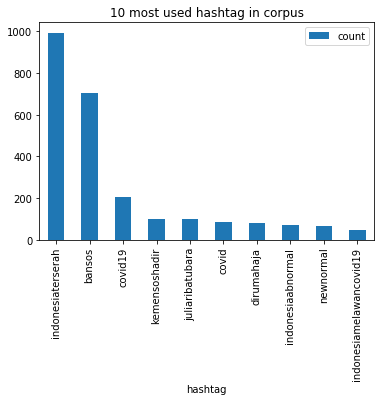

In [47]:
from pandas import DataFrame
Data = {'hashtag': [],
        'count': []
       }
dfHashtag = DataFrame(Data,columns=['hashtag','count'])
dfHashtag = dfHashtag.append(pd.DataFrame([["indonesiaterserah",994],["bansos",704],["covid19",205],["kemensoshadir",101],["juliaribatubara",97],
                                          ["covid",83],["dirumahaja",82],["indonesiaabnormal",69],["newnormal",66],["indonesiamelawancovid19",45],
                                          ],columns=dfHashtag.columns),ignore_index=True)
dfHashtag = dfHashtag.astype({'hashtag': 'str', 'count': 'int'})
dfHashtag
# a simple line plot
dfHashtag.plot(kind='bar',x='hashtag',y='count',title="10 most used hashtag in corpus")

In [48]:
positive_tweet = []
for row in dataset:
    if row['intent'] == 'positive':
        word_tokens = word_tokenize(row['tweet']) 
        for x in range(len(word_tokens)):
            #check if word used in hashtag
            #if word_tokens[x] not in hashtag:
            positive_tweet.append(word_tokens[x])
#print(Counter(positive_tweet))

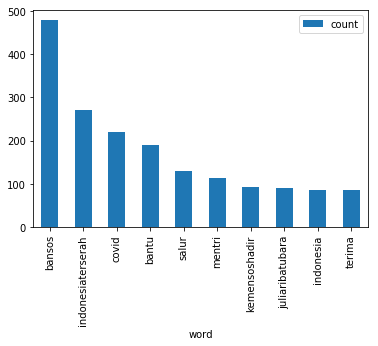

In [49]:
Data = {'word': [],
        'count': []
       }
dfPositive = DataFrame(Data,columns=['word','count'])
dfPositive = dfPositive.append(pd.DataFrame([["bansos",478],["indonesiaterserah",271],["covid",219],["bantu",190],["salur",129],["mentri",113],
                                          ["kemensoshadir",94],["juliaribatubara",91],["indonesia",86],["terima",86]
                                          ],columns=dfPositive.columns),ignore_index=True)
dfPositive = dfPositive.astype({'word': 'str', 'count': 'int'})
dfPositive
# a simple line plot
dfPositive.plot(kind='bar',x='word',y='count')

In [50]:
negative_tweet = []
for row in dataset:
    if row['intent'] == 'negative':
        word_tokens = word_tokenize(row['tweet']) 
        for x in range(len(word_tokens)):
            #check if word used in hashtag
            #if word_tokens[x] not in hashtag:
            negative_tweet.append(word_tokens[x])
#print(Counter(negative_tweet))

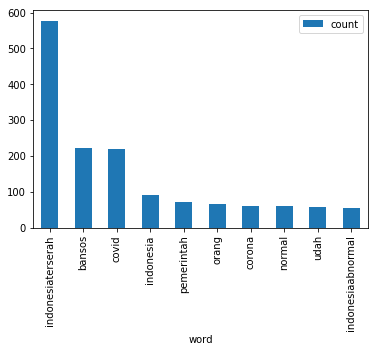

In [51]:
Data = {'word': [],
        'count': []
       }
dfNegative = DataFrame(Data,columns=['word','count'])
dfNegative = dfNegative.append(pd.DataFrame([["indonesiaterserah",577],["bansos",224],["covid",221],["indonesia",92],["pemerintah",72],["orang",67],
                                          ["corona",60],["normal",60],["udah",57],["indonesiaabnormal",55]
                                          ],columns=dfNegative.columns),ignore_index=True)
dfNegative = dfNegative.astype({'word': 'str', 'count': 'int'})
dfNegative
# a simple line plot
dfNegative.plot(kind='bar',x='word',y='count')